## H C with included time features for optimal predicting

In [1]:
import math
import pandas as pandas
import numpy as np
import matplotlib
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score
from math import floor, ceil
from scipy.cluster.hierarchy import single, cophenet
from scipy.spatial.distance import pdist, squareform
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

data = pandas.read_json("../data/water_loss_data_set_1.json")

data = data[(data.timeStamp != "0000-00-00 00:00:00" ) & (data.timeStamp != "2000-01-01 00:00:00")] 
data = data[(data.tot1 != 0 ) & (data.analog2 != 0)]
data["timeStamp"] = pandas.to_datetime(data["timeStamp"], format="%Y-%m-%d %H:%M")

data["timeStamp"] = data["timeStamp"].dt.floor('h')
data["timeStamp"] = data["timeStamp"].dt.strftime("%Y-%m-%d %H:%M")
data["timeStamp"] = pandas.to_datetime(data["timeStamp"], format="%Y-%m-%d %H:%M")

data_249 = data[data['idflowmeter'] == "MAG8000_024905H318"]
data_248 = data[data['idflowmeter'] == "MAG8000_024805H318"]

data_249 = data_249.groupby("timeStamp").mean()
data_248 = data_248.groupby("timeStamp").mean()
data_248

,tot1,tot2,analog2
timeStamp,,,
2018-12-11 12:00:00,161.873400,0.00,0.819200
2018-12-11 13:00:00,264.282667,0.00,0.820333
2018-12-11 14:00:00,371.478000,0.00,0.818333
2018-12-11 15:00:00,487.519333,0.00,0.813167
2018-12-11 16:00:00,601.331833,0.00,0.810833
...,...,...,...
2020-04-01 10:00:00,977299.898333,-4713.21,1.527333
2020-04-01 11:00:00,977333.727167,-4713.21,1.528500
2020-04-01 12:00:00,977369.184833,-4713.21,1.530500


## Preparing data

In [14]:
"""if type(data_249.index) == pandas.core.indexes.datetimes.DatetimeIndex:
    data_249.index = data_249.index.strftime("%Y-%m-%d %H:00")
    data_248.index = data_248.index.strftime("%Y-%m-%d %H:00")"""
pandas.options.mode.chained_assignment = None  # default='warn'

def selected_data(data_fun, start, end):
    data_fun['hour'] = [i.hour for i in data_fun.index]
    data_fun['day'] = [i.hour for i in data_fun.index]
    data_fun['month'] = [i.hour for i in data_fun.index]
    data_fun['year'] = [i.hour for i in data_fun.index]
    
    data_fun = data_fun.loc[(data_fun.index >= start) & (data_fun.index <= end)]
    time = data_fun.index.strftime("%Y-%m-%d %H:00").to_numpy()
        
    data_fun = ((data_fun - data_fun.min()) / (data_fun.max() - data_fun.min()))
    
    # to give it more weight
    # data_fun['analog2'] = data_fun['analog2'].astype(float) * 1.10
    
    data_fun = data_fun.reset_index()
    del data_fun["timeStamp"]
    del data_fun["tot2"]
    
    data_fun = data_fun.reindex(['analog2', 'hour', 'day', 'month', 'year', 'tot1'],axis=1)
    return data_fun, time

In [15]:
temp, time = selected_data(data_249, "2019-04-12 12:00:00", "2019-05-18 12:00:00")
temp

,analog2,hour,day,month,year,tot1
0,0.904444,0.521739,0.521739,0.521739,0.521739,0.000000
1,0.907407,0.565217,0.565217,0.565217,0.565217,0.001256
2,0.905926,0.608696,0.608696,0.608696,0.608696,0.002543
3,0.897037,0.652174,0.652174,0.652174,0.652174,0.003884
4,0.893333,0.695652,0.695652,0.695652,0.695652,0.005409
...,...,...,...,...,...,...
860,0.892593,0.347826,0.347826,0.347826,0.347826,0.993377
861,0.902963,0.391304,0.391304,0.391304,0.391304,0.994954
862,0.905185,0.434783,0.434783,0.434783,0.434783,0.996731
863,0.932593,0.478261,0.478261,0.478261,0.478261,0.998420


In [16]:
def find_optimal_t_cluster(L, matrix_fun, num_of_clusters):
    max_silhuete = [-1, 0]
    arr = []

    max_val = (floor(max(sch.maxdists(L)) * 100) / 100.0) * 0.66
    # print(max_val)
    t_f = max_val

    while(True):
        predictions = sch.fcluster(L, t=t_f, criterion="distance").ravel()
        score = round(silhouette_score(matrix_fun, predictions, metric="cityblock"), 3)
        arr.append((score, round(t_f, 4)))
        
        num_of_c = len(set(predictions))
        if num_of_c == num_of_clusters:
            max_silhuete[0] = score
            max_silhuete[1] = round(t_f, 4)
            break
        elif num_of_c < num_of_clusters:
            t_f = t_f - (t_f / 2)
        else:
            t_f = t_f + (t_f / 2)
        # print(t_f)

    print("The best value for t is t =", max_silhuete[1])
    return arr, t_f

def get_anomaly_coeficient(sorted_arr):
    return sorted_arr[len(sorted_arr) - 1][1] * 0.05

def generate_sizes(class_dict):
    class_len_arr = []
    for i in class_dict:
        class_len_arr.append([i, len(class_dict[i])])
        
    class_sorted_arr = sorted(class_len_arr, key=lambda x: x[1])
    
    size_arr = []
    anomaly_koef = get_anomaly_coeficient(class_sorted_arr)

    for i in class_len_arr:
        if i[1] <= anomaly_koef:
            size_arr.append(200)
            
        elif i[1] <= (anomaly_koef * 2):
            size_arr.append(100)
        else:
            size_arr.append(20)
        
    return size_arr

def generate_xticks(start_date, end_date):
    start_date = pandas._libs.tslibs.Timestamp(start_date) 
    end_date = pandas._libs.tslibs.Timestamp(end_date) 
    
    difference = ceil((ceil((end_date - start_date).days) / 10))
    date_range_seconds = pandas.date_range(start=(start_date), end=(end_date), freq=str(difference)+ "D")
    
    date_range_string = []
    for i in date_range_seconds:
        ready_string = str(i)[:-5] + "00"
        date_range_string.append(ready_string)  
        
    return date_range_string

def draw_classes(x_time, matrix_X, class_dict, start, end):
    color_array = ["yellowgreen", "coral", "dodgerblue", "red", "springgreen", "aqua", 
                   "mistyrose", "deeppink", "bisque", "indigo"]
    size_arr = generate_sizes(class_dict)
    # print(len(x_time), x_time[:5], "\n", len(matrix_X), matrix_X[:5, 0])
    
    fig = plt.figure(figsize=(18, 12), dpi= 100, facecolor='w')
    plt.plot(x_time, matrix_X[:, 0], color="blue")
    
    for num, element in enumerate(class_dict):
        label_name = "Class: " + str(element) + " - Num of elements: " + str(len(class_dict[element]))
        
        x_value_date = [x[1] for x in class_dict[element]]
        y_value_pressure = [matrix_X[x[0]][0] for x in class_dict[element]]
        plt.scatter(x_value_date, y_value_pressure, color=color_array[num], s=size_arr[num], label=label_name)

    plt.ylabel('Pressure in bar ?')
    plt.xlabel('Date')
    plt.xticks(generate_xticks(start, end), rotation=40) 
    plt.legend()
    
    plt.rc('xtick',labelsize=8)
    plt.title('Time')
    plt.show()


In [17]:
def main_function(start, end, data_fun, number_of_clusters):
    data_sel, time_l = selected_data(data_fun, start, end)  
    matrix = data_sel.values

    if len(matrix) < 1:
        raise Exception("No data for this date ")    
    matrix_X = matrix[:, :4]  
    print(matrix_X[:2])
    
    L = sch.linkage(matrix_X, method="average", metric="cityblock")
    
    arr_, t_best = find_optimal_t_cluster(L, matrix_X, number_of_clusters)
    predictions = sch.fcluster(L, t=t_best, criterion="distance").ravel()

    plt.figure(figsize=(25, 15))

    D  = sch.dendrogram(L, leaf_font_size=15, orientation="left", 
                            show_contracted=True, 
                            truncate_mode='lastp',  # last p merged clusters
                            p=number_of_clusters    # show only the last p merged clusters
                           )
    plt.xlabel("Razdalja")
    plt.ylabel("Datum")
    plt.show()
    
    class_dict = dict()
    
    for index, combined in enumerate(zip(time_l, predictions)):
        value, predicted_class = combined
        if predicted_class not in class_dict:
            class_dict[predicted_class] = [(index, value)]
        else:
            class_dict[predicted_class].append((index, value))
     
    draw_classes(time_l, matrix_X, class_dict, start, end)

[[0.90921228 0.52173913 0.52173913 0.52173913]
 [0.91722296 0.56521739 0.56521739 0.56521739]]
The best value for t is t = 0.3702


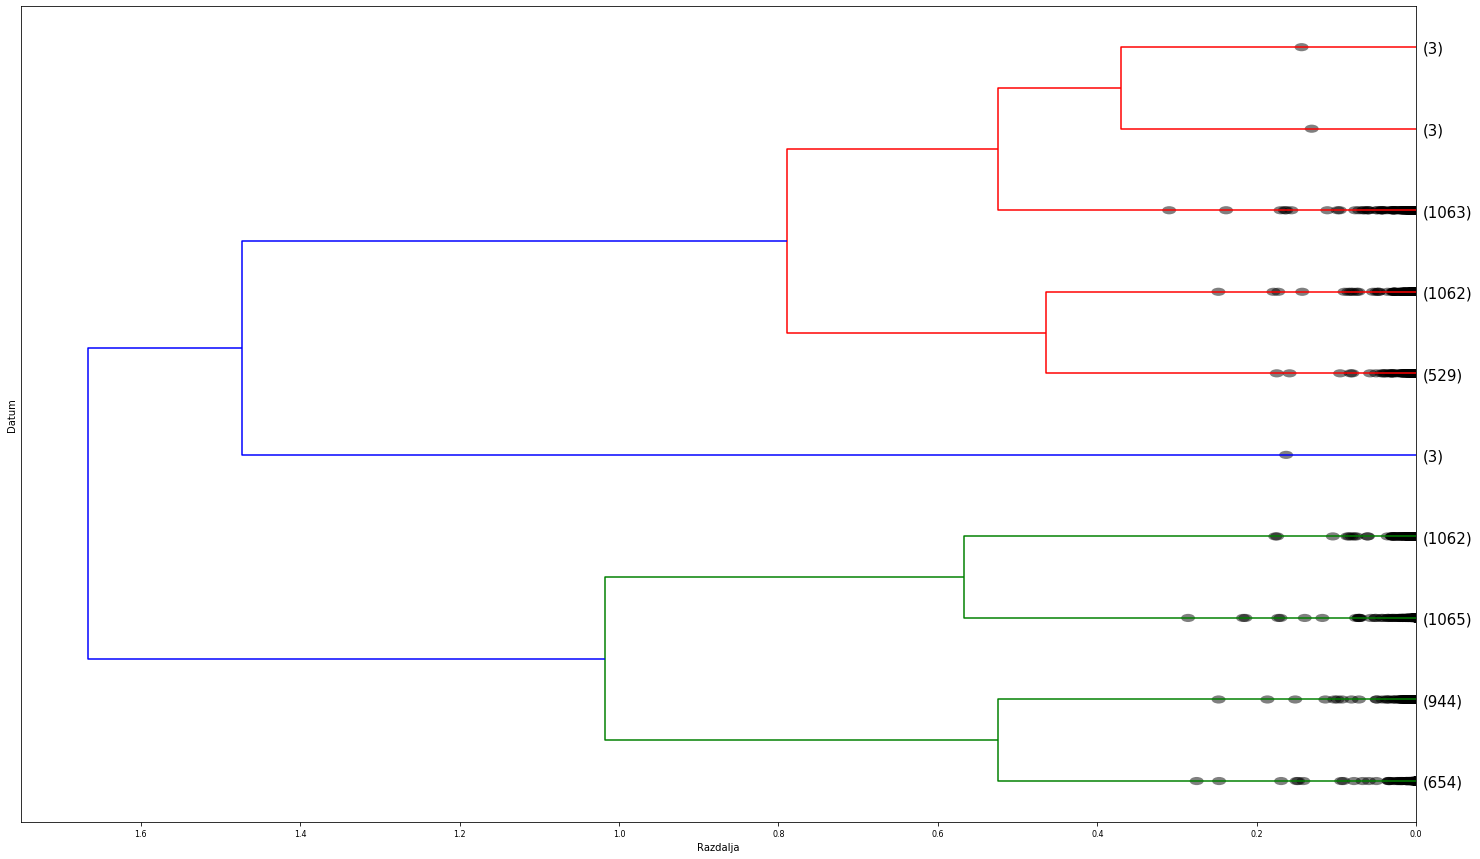

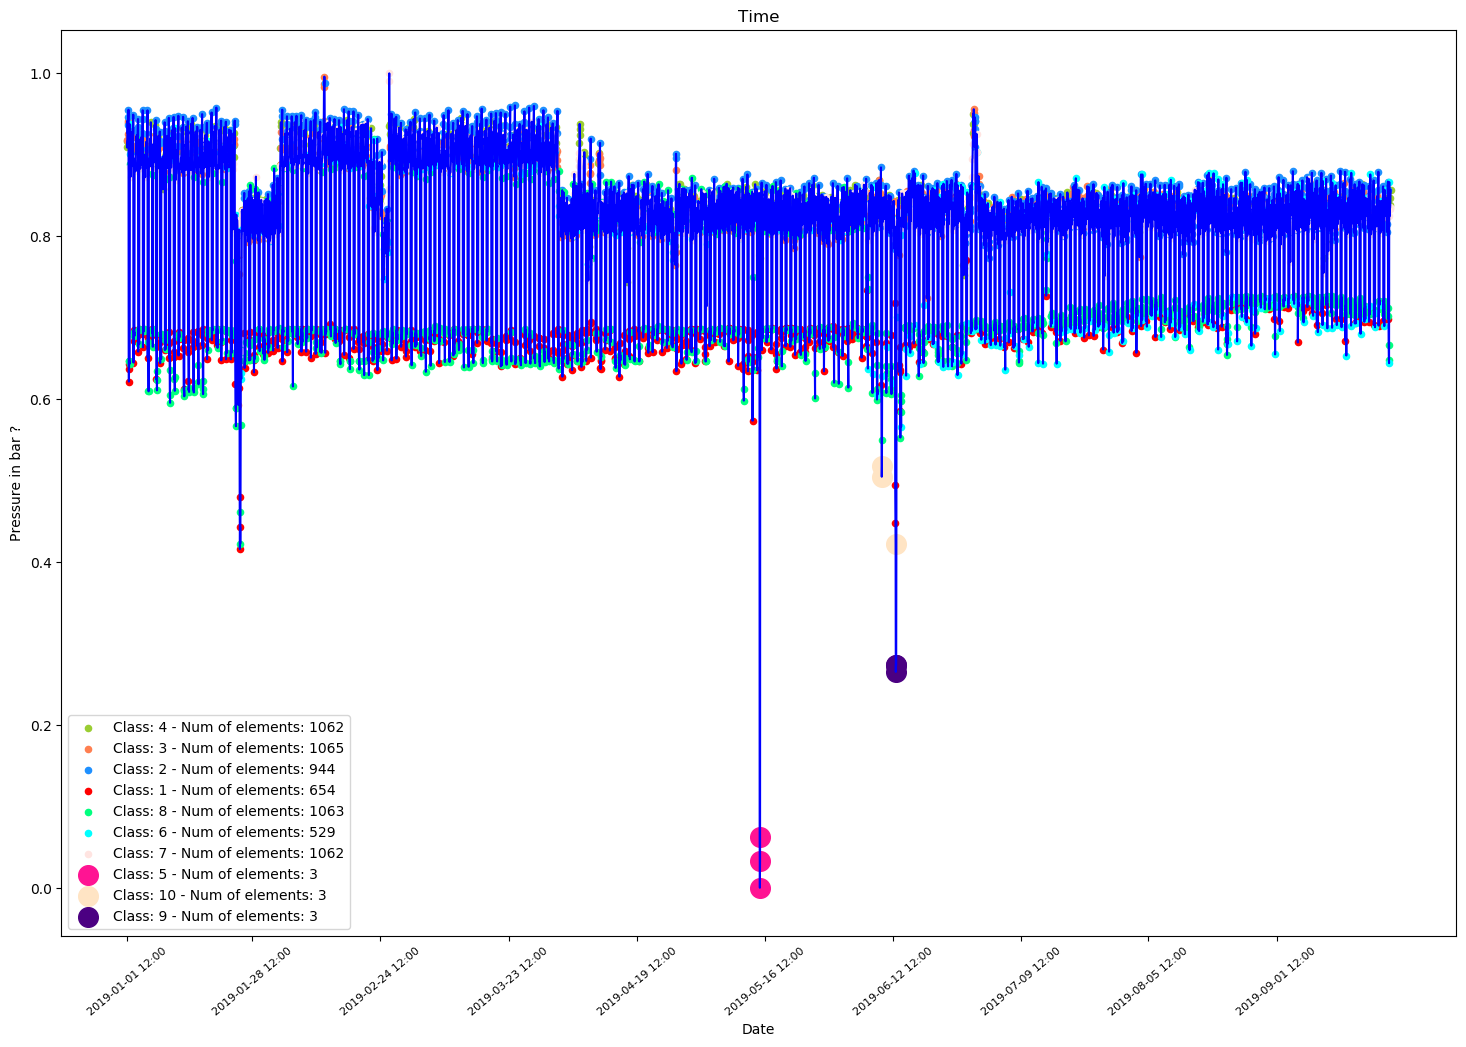

In [18]:
main_function("2019-01-01 12:00:00", "2019-09-25 12:00:00", data_249, 10)

In [13]:
temp

,analog2,hour,day,month,year,tot1
0,0.994889,0.521739,0.521739,0.521739,0.521739,0.000000
1,0.998148,0.565217,0.565217,0.565217,0.565217,0.001256
2,0.996519,0.608696,0.608696,0.608696,0.608696,0.002543
3,0.986741,0.652174,0.652174,0.652174,0.652174,0.003884
4,0.982667,0.695652,0.695652,0.695652,0.695652,0.005409
...,...,...,...,...,...,...
860,0.981852,0.347826,0.347826,0.347826,0.347826,0.993377
861,0.993259,0.391304,0.391304,0.391304,0.391304,0.994954
862,0.995704,0.434783,0.434783,0.434783,0.434783,0.996731
863,1.025852,0.478261,0.478261,0.478261,0.478261,0.998420
